## Semi-supervised pattern recognition

Let us now explore two, more elaborate, classification tasks, which showcase the
benefit of using logical reasoning alongside machine learning.

The tasks consist in predicting the sum of two numbers given in input. We have the images for these numbers but we do not
know their classes, namely their labels. The only thing we know is their sum. In particular, the first task is simpler
and consists in predicting the sum of two single-digit numbers. The second one is more complicated since it consists in
predicting the sum of two multi-digits numbers.

To create our dataset, we use the popular MNIST dataset, which contains labelled manuscripted digits.

**Single digits addition:**
consider the predicate $addition(X, Y, n)$, where $X$ and $Y$ are
images of digits, and $n$ is a natural number corresponding to the sum of these digits. This predicate should return an
estimate of the validity of the addition. For instance, $addition(img(8), img(3), 11)$ is a
valid addition, while $addition(img(3), img(3), 5)$ is not. In this example, $img(x)$ means "an image of a $x$", where $x$ is
a digit label. It has not to be confused with a logical function.

**Multi digits addition:**
the experiment is extended to numbers with more than one
digit. Consider the predicate $addition([img(X_1), img(X_2)],[img(Y_1), img(Y_2)], n)$, where $[img(X_1), img(X_2)]$ and
$[img(Y_1), img(Y_2)]$ are lists of images of digits, representing two multi-digit numbers, and $n$ is a natural
number corresponding to the sum of the two multi-digit numbers. For instance,
$addition([img(2), img(0)], [img(1), (7)], 37)$ is a valid addition, while $addition([img(5), img(4)], [img(9), img(0)], 50)$
is not.

A natural Neural-Symbolic approach is to seek to learn a single digit classifier and
benefit from knowledge readily available about the properties of the addition in this case.
For instance, suppose that a predicate $digit(x,d)$ gives the likelihood of an image $x$
being of digit $d$. A definition for $addition(img(3), img(8), 11)$ in LTN is:

$\exists d_1, d_2 : d_1 + d_2 = 11 \text{ } (digit(img(3), d_1) \land digit(img(8), d_2))$.

The above task is made more complicated by not providing labels for the
single digit images during training. Instead, training takes place on pairs of images
with labels made available for the result only, that is, the sum of the individual
labels. The single digit classifier is not explicitly trained by itself. Its output is a
latent information which is used by the logic. However, this does not pose a problem
for end-to-end Neural-Symbolic systems such as LTN, for which the
gradients can propagate through the logical structures.

We start by illustrating an LTN theory that can be used to learn the predicate
$digit$. The specification of the theory below is for the single digit addition example,
although it can be extended easily to the multiple digits case:

**Domains:**
- $images$, denoting the MNIST digit images;
- $results$, denoting the integers which are the labels for the results of the additions;
- $digits$, denoting the digits from 0 to 9.

**Variables:**
- $x, y$ ranging over the MNIST images;
- $n$ for the labels, i.e., the results of the additions;
- $d_1, d_2$ ranging over digits;
- $D(x) = D(y) = images$;
- $D(n) = results$;
- $D(d_1) = d(d_2) = digits$.

**Predicates:**
- $digit(x, d)$ for the single digit classifier, where $d$ is a term denoting a digit
constant or a digit variable. The classifier should return the probability of an
image $x$ being of digit $d$;
- $D_{in}(digit) = images,digits$.

**Axioms:**

Single digit addition:

$\forall Diag(x, y, n) \text{ } (\exists d_1, d_2 : d_1 + d_2 = n \text{ } (digit(x, d_1) \land digit(y, d_2)))$

Multiple digit addition:

$\forall Diag(x_1, x_2, y_1, y_2, n) \text{ } (\exists d_1, d_2, d_3, d_4: 10d_1 + d_2 + 10d_3 + d_4 = n \text{ } (digit(x_1, d_1) \land digit(x_2, d_2) \land digit(y_1, d_3) \land digit(y_2, d_4)))$

Notice the use of $Diag$: when grounding $x,y,n$ with three sequences of values,
the *i-th* examples of each variable are matching. That is, $(\mathcal{G}(x)_i, \mathcal{G}(y)_i, \mathcal{G}(n)_i)$ is
a tuple from our dataset of valid additions. Using the diagonal quantification,
LTN aggregates pairs of images and their corresponding result, rather than any
combination of images and results.

Notice also the guarded quantification: by quantifying only on the "intermediate labels" (not given during training)
that could add up to the result label
(given during training), we incorporate symbolic information into the system.


**Grounding:**
- $\mathcal{G}(images)=[0, 1]^{28 \times 28 \times 1}$. The MNIST dataset has images of 28 by 28 pixels.
The images are grayscale and have just one channel. The RGB pixel values from
0 to 255 of the MNIST dataset are scaled to the range [0, 1];
- $\mathcal{G}(results)=\mathbb{N}$;
- $\mathcal{G}(digits) = {0, 1, \dots, 9}$;
- $\mathcal{G}(x) \in[0,1]^{m \times 28 \times 28 \times 1}, \mathcal{G}(y) \in[0,1]^{m \times 28 \times 28 \times 1}, \mathcal{G}(n) \in \mathbb{N}^{m}$.
Notice the use of the same number $m$ of examples for each of these variables as they are supposed
to match one-to-one due to the use of $Diag$;
- $\mathcal{G}\left(d_{1}\right)=\mathcal{G}\left(d_{2}\right)=\langle 0,1, \ldots, 9\rangle$;
- $\mathcal{G}(digit \mid \theta): x, d \rightarrow \operatorname{onehot}(d)^{\top} \cdot \operatorname{softmax}\left(\operatorname{CNN}_{\theta}(x)\right)$, where $CNN$
is a Convolutional Neural Network with 10 output neurons for each class. Notice that, in contrast
with the previous examples, $d$ is an integer label; $onehot(d)$ converts it into a
one-hot label.


### Dataset

Now, let's import and create the dataset.

The MNIST dataset contains 70000 images, subdivided into 60000 examples for training and 10000 for test. For our task,
we need to create an ad-hoc dataset starting from the MNIST dataset.

For the single digit case, the first 30000 images of the training set are used as left operands for the addition, while
the last 30000 images are used as right operands. The sum of the labels of the left and right operands is used as target.
The same process is repeated to create the test set.

For the multiple digit case, the training set is divided into four groups of 15000 images. The first two groups form the
left operands for the additions, while the last two groups the right operands. The target is created in a similar manner
to the previous case.


In [42]:
import torch
import pandas as pd
import torchvision

def get_mnist_dataset_for_digits_addition(single_digit=True):
    """
    It prepares the dataset for the MNIST single digit or multi digits addition example of the LTN paper.

    :param single_digit: whether the dataset has to be generated for the single digit or multi digits example (please,
    carefully read the examples in the paper to understand the differences between the two).
    :return: a tuple of two elements. The first element is the training set, while the second element is the test set.
    Both training set and test set are lists that contain the following information:
        1. a list [left_operands, right_operands], where left_operands is a list of MNIST images that are used as the
        left operand of the addition, while right_operands is a list of MNIST images that are used as the right operand
        of the addition;
        2. a list containing the summation of the labels of the images contained in the list at point 1. The label of
        the left operand is added to the label of the right operand, and the target label is generated. This represents
        the target of the digits addition task.
    Note that this is the output of the process for the single digit case. In the multi digits case the list at point
    1 will have 4 elements since in the multi digits case four digits are involved in each addition (two digits
    represent the first operand and two digits the second operand).
    """
    if single_digit:
        n_train_examples = 30000
        n_test_examples = 5000
        n_operands = 2
    else:
        n_train_examples = 15000
        n_test_examples = 2500
        n_operands = 4

    mnist_train = torchvision.datasets.MNIST("./datasets/", train=True, download=True,
                                             transform=torchvision.transforms.ToTensor())
    mnist_test = torchvision.datasets.MNIST("./datasets/", train=False, download=True,
                                            transform=torchvision.transforms.ToTensor())

    train_imgs, train_labels, test_imgs, test_labels = mnist_train.data, mnist_train.targets, \
                                                       mnist_test.data, mnist_test.targets

    train_imgs, test_imgs = train_imgs / 255.0, test_imgs / 255.0

    train_imgs, test_imgs = torch.unsqueeze(train_imgs, 1), torch.unsqueeze(test_imgs, 1)

    imgs_operand_train = [train_imgs[i * n_train_examples:i * n_train_examples + n_train_examples]
                          for i in range(n_operands)]
    labels_operand_train = [train_labels[i * n_train_examples:i * n_train_examples + n_train_examples]
                            for i in range(n_operands)]

    imgs_operand_test = [test_imgs[i * n_test_examples:i * n_test_examples + n_test_examples]
                         for i in range(n_operands)]
    labels_operand_test = [test_labels[i * n_test_examples:i * n_test_examples + n_test_examples]
                           for i in range(n_operands)]

    if single_digit:
        label_addition_train = labels_operand_train[0] + labels_operand_train[1]
        label_addition_test = labels_operand_test[0] + labels_operand_test[1]
    else:
        label_addition_train = 10 * labels_operand_train[0] + labels_operand_train[1] + \
                               10 * labels_operand_train[2] + labels_operand_train[3]

        label_addition_test = 10 * labels_operand_test[0] + labels_operand_test[1] + \
                              10 * labels_operand_test[2] + labels_operand_test[3]

    train_set = [torch.stack(imgs_operand_train, dim=1), label_addition_train]
    test_set = [torch.stack(imgs_operand_test, dim=1), label_addition_test]

    return train_set, test_set

# single digit dataset
single_d_train_set, single_d_test_set = get_mnist_dataset_for_digits_addition(single_digit=True)
# multi digit dataset
multi_d_train_set, multi_d_test_set = get_mnist_dataset_for_digits_addition(single_digit=False)

Just for illustration, we show the first example of the training set for the single digit case. This should help in
understanding how the dataset is created.

Operands are displayed in the following images:


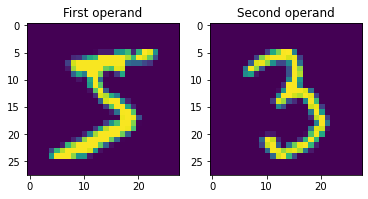

The target label (sum) for these operands is: 8


In [43]:
import matplotlib.pyplot as plt
first_example_images = single_d_train_set[0][0]
first_example_label = single_d_train_set[1][0]

print("Operands are displayed in the following images:")
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
imgplot = plt.imshow(first_example_images[0].permute(1, 2, 0))
ax.set_title('First operand')
ax = fig.add_subplot(1, 2, 2)
imgplot = plt.imshow(first_example_images[1].permute(1, 2, 0))
ax.set_title('Second operand')
plt.show()
print("The target label (sum) for these operands is: %d" % first_example_label.item())


### LTN setting

In order to define our knowledge base (axioms), we need to define predicate $digit$, variables $d_1$, $d_2$, $d_3$, $d_4$,
connectives, universal and existential quantifiers, and the `SatAgg` operator.

For connectives and quantifiers, we use the stable product configuration (seen in the tutorials).

For predicate $digit$, we have two models. The first one implements a $CNN$ which outputs the logits for the ten classes of
the MNIST dataset, given an image $x$ in input. The second model takes as input a labelled example $(x,d)$, it computes the logits
using the first model and then returns the prediction (*softmax*) for class $d$. In other words, it computes the likelihood
of image $d$ being of digit $d$.

We need two separated models because we need both logits and probabilities. Logits are used to compute the classification
accuracy, while probabilities are interpreted as truth values to compute the satisfaction level of the knowledge base.

The variables $d_1$, $d_2$, $d_3$, and $d_4$ represent the 10 digit labels of the MNIST dataset, namely they are the sequence $\langle 0,1, \ldots, 9\rangle$.

`SatAgg` is defined using the `pMeanError` aggregator.

In [44]:
from torch.nn.init import xavier_uniform_, normal_, kaiming_uniform_
import ltn

# we define the variables
d_1 = ltn.Variable("d_1", torch.tensor(range(10)))
d_2 = ltn.Variable("d_2", torch.tensor(range(10)))
# these are used only in the multi digit case
d_3 = ltn.Variable("d_3", torch.tensor(range(10)))
d_4 = ltn.Variable("d_4", torch.tensor(range(10)))

# we define predicate digit
class MNISTConv(torch.nn.Module):
    """
    CNN that returns linear embeddings for MNIST images. It is used in the single digit and multi digits addition
    examples of the LTN paper.
    Args:
        conv_channels_sizes: tuple containing the number of channels of the convolutional layers of the model. The first
        element of the tuple must be the number of input channels of the first conv layer, while the last element
        of the tuple must be the number of output channels of the last conv layer. Specifically, the number of conv
        layers constructed is equal to `len(conv_channels_sizes) - 1`;
        kernel_sizes: tuple containing the sizes of the kernels used in the conv layers of the architecture;
        linear_layers_sizes: tuple containing the sizes of the linear layers used as the final layers of the
        architecture. The first element of the tuple must be the number of features in input to the first linear layer,
        while the last element of the tuple must be the number of output features of the last linear layer. Specifically,
        the number of layers constructed is equal to `len(linear_layers_sizes) - 1`.
    """
    def __init__(self, conv_channels_sizes=(1, 6, 16), kernel_sizes=(5, 5), linear_layers_sizes=(256, 100)):
        super(MNISTConv, self).__init__()
        self.conv_layers = torch.nn.ModuleList([torch.nn.Conv2d(conv_channels_sizes[i - 1], conv_channels_sizes[i],
                                                                kernel_sizes[i - 1])
                                                  for i in range(1, len(conv_channels_sizes))])
        self.relu = torch.nn.ReLU()  # relu is used as activation for the conv layers
        self.tanh = torch.nn.Tanh()  # tanh is used as activation for the linear layers
        self.maxpool = torch.nn.MaxPool2d((2, 2))
        self.linear_layers = torch.nn.ModuleList([torch.nn.Linear(linear_layers_sizes[i - 1], linear_layers_sizes[i])
                                                  for i in range(1, len(linear_layers_sizes))])
        self.batch_norm_layers = torch.nn.ModuleList([torch.nn.BatchNorm1d(linear_layers_sizes[i])
                                                      for i in range(1, len(linear_layers_sizes))])

        self.init_weights()

    def forward(self, x):
        for conv in self.conv_layers:
            x = self.relu(conv(x))
            x = self.maxpool(x)
        x = torch.flatten(x, start_dim=1)
        for i in range(len(self.linear_layers)):
            x = self.tanh(self.batch_norm_layers[i](self.linear_layers[i](x)))
        return x

    def init_weights(self):
        r"""Initialize the weights of the network.
        Weights of conv layers are initialized with the :py:func:`torch.nn.init.kaiming_uniform_` initializer,
        weights of linear layers are initialized with the :py:func:`torch.nn.init.xavier_uniform_` initializer,
        while biases are initialized with the :py:func:`torch.nn.init.normal_` initializer.
        """
        for layer in self.conv_layers:
            kaiming_uniform_(layer.weight)
            normal_(layer.bias)

        for layer in self.linear_layers:
            xavier_uniform_(layer.weight)
            normal_(layer.bias)


class SingleDigitClassifier(torch.nn.Module):
    """
    Model classifying one MNIST digit image into 10 possible classes. It outputs the logits, so it is not a normalized
    output. It has a convolutional part in the initial layers of the architecture and a linear part in the last
    layers of the architecture. To build the convolutional part a pre-configured convolutional model is used.
    Args:
        layers_sizes: tuple containing the sizes of the linear layers used as the final layers of the
        architecture. The first element of the tuple must be the number of features in input to the first linear layer,
        while the last element of the tuple must be the number of output features of the last linear layer. Specifically,
        the number of layers constructed is equal to `len(layers_sizes) - 1`.
    """
    def __init__(self, layers_sizes=(100, 84, 10)):
        super(SingleDigitClassifier, self).__init__()
        self.mnistconv = MNISTConv()  # this is the convolutional part of the architecture
        self.tanh = torch.nn.Tanh()  # tanh is used as activation for the linear layers
        self.linear_layers = torch.nn.ModuleList([torch.nn.Linear(layers_sizes[i - 1], layers_sizes[i])
                                                  for i in range(1, len(layers_sizes))])
        self.batch_norm_layers = torch.nn.ModuleList([torch.nn.BatchNorm1d(layers_sizes[i])
                                                      for i in range(1, len(layers_sizes))])
        self.init_weights()

    def forward(self, x):
        x = self.mnistconv(x)
        for i in range(len(self.linear_layers) - 1):
            x = self.tanh(self.batch_norm_layers[i](self.linear_layers[i](x)))
        return self.linear_layers[-1](x)  # in the last layer a sigmoid or a softmax has to be applied

    def init_weights(self):
        """Initialize the weights of the linear layers of the network.
        Weights are initialized with the :py:func:`torch.nn.init.xavier_uniform_` initializer,
        while biases are initialized with the :py:func:`torch.nn.init.normal_` initializer.
        """
        for layer in self.linear_layers:
            xavier_uniform_(layer.weight)
            normal_(layer.bias)


class LogitsToPredicate(torch.nn.Module):
    """
    This model has inside a logits model, that is a model which compute logits for the classes given an input example x.
    The idea of this model is to keep logits and probabilities separated. The logits model returns the logits for an example,
    while this model returns the probabilities given the logits model.

    In particular, it takes as input an example x and a class label d. It applies the logits model to x to get the logits.
    Then, it applies a softmax function to get the probabilities per classes. Finally, it returns only the probability related
    to the given class d.
    """
    def __init__(self, logits_model):
        super(LogitsToPredicate, self).__init__()
        self.logits_model = logits_model
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x, d):
        logits = self.logits_model(x)
        probs = self.softmax(logits)
        out = torch.gather(probs, 1, d)
        return out

# single digit
cnn_s_d = SingleDigitClassifier()
Digit_s_d = ltn.Predicate(LogitsToPredicate(cnn_s_d)).to(ltn.device)
# multi digit
cnn_m_d = SingleDigitClassifier()
Digit_m_d = ltn.Predicate(LogitsToPredicate(cnn_m_d)).to(ltn.device)

# we define the connectives, quantifiers, and the SatAgg
And = ltn.Connective(ltn.fuzzy_ops.AndProd())
Exists = ltn.Quantifier(ltn.fuzzy_ops.AggregPMean(p=2), quantifier="e")
Forall = ltn.Quantifier(ltn.fuzzy_ops.AggregPMeanError(p=2), quantifier="f")
SatAgg = ltn.fuzzy_ops.SatAgg()

### Utils

Now, we need to define some utility classes and functions.

We define a standard PyTorch data loader, which takes as input the dataset and returns a generator of batches of data.
In particular, we need a data loader instance for training data and one for testing data. We create these loaders both for
the single digit case and the multiple digit case.

In [45]:
import numpy as np

# this is a standard PyTorch DataLoader to load the dataset for the training and testing of the model
class DataLoader(object):
    def __init__(self,
                 fold,
                 batch_size=1,
                 shuffle=True):
        self.fold = fold
        self.batch_size = batch_size
        self.shuffle = shuffle

    def __len__(self):
        return int(np.ceil(self.fold[0].shape[0] / self.batch_size))

    def __iter__(self):
        n = self.fold[0].shape[0]
        idxlist = list(range(n))
        if self.shuffle:
            np.random.shuffle(idxlist)

        for _, start_idx in enumerate(range(0, n, self.batch_size)):
            end_idx = min(start_idx + self.batch_size, n)
            digits = self.fold[0][idxlist[start_idx:end_idx]]
            addition_labels = self.fold[1][idxlist[start_idx:end_idx]]

            yield digits, addition_labels

# create train and test loader
single_train_loader = DataLoader(single_d_train_set, 32, shuffle=True)
single_test_loader = DataLoader(single_d_test_set, 32, shuffle=False)
multi_d_train_loader = DataLoader(multi_d_train_set, 32, shuffle=True)
multi_d_test_loader = DataLoader(multi_d_test_set, 32, shuffle=False)

### Learning

Let us define $D$ the data set of all examples. The objective function is given by $\operatorname{SatAgg}_{\phi \in \mathcal{K}} \mathcal{G}_{\boldsymbol{\theta}, x \leftarrow \boldsymbol{D}}(\phi)$.

In practice, the optimizer uses the following loss function:

$\boldsymbol{L}=\left(1-\underset{\phi \in \mathcal{K}}{\operatorname{SatAgg}} \mathcal{G}_{\boldsymbol{\theta}, x \leftarrow \boldsymbol{B}}(\phi)\right)$

where $B$ is a mini batch sampled from $D$.

### Single digit

In the following, we learn our LTN for the single digit case. We train our model for 20 epochs and use the `Adam`
optimizer with a batch size of 32.

Note that hyper-parameter $p$ for existential quantification follows a schedule, changing from $p=1$ to $p=6$ gradually
with the number of training epochs. If you are interested in the motivation behind this choice, consider
reading the paper.

The accuracy is measured by predicting the digit values using the predicate $digit$ and reporting the ratio of
examples for which the addition is correct. Within each epoch, satisfaction level and accuracy on both training and
test data are visualized.

The following figure shows the LTN computational graph for the single digit case.

![Computational graph](/examples/images/semisupervised-single.png)

In [46]:
optimizer = torch.optim.Adam(Digit_s_d.parameters(), lr=0.001)

for epoch in range(20):
    # scheduling of the parameter p for the existential quantifier as described in the LTN paper
    if epoch in range(0, 4):
        p = 1
    if epoch in range(4, 8):
        p = 2
    if epoch in range(8, 12):
        p = 4
    if epoch in range(12, 20):
        p = 6
    train_loss, test_loss = 0.0, 0.0
    train_sat, test_sat = 0.0, 0.0
    train_acc, test_acc = 0.0, 0.0
    # train step
    for batch_idx, (operand_images, addition_label) in enumerate(single_train_loader):
        optimizer.zero_grad()
        # ground variables with current batch data
        images_x = ltn.Variable("x", operand_images[:, 0])
        images_y = ltn.Variable("y", operand_images[:, 1])
        labels_z = ltn.Variable("z", addition_label)
        sat_agg = Forall(
            ltn.diag(images_x, images_y, labels_z),
            Exists(
                [d_1, d_2],
                And(Digit_s_d(images_x, d_1), Digit_s_d(images_y, d_2)),
                cond_vars=[d_1, d_2, labels_z],
                cond_fn=lambda d1, d2, z: torch.eq(d1.value + d2.value, z.value),
                p=p
            )).value
        loss = 1. - sat_agg
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_sat += sat_agg
        # compute train accuracy
        predictions_x = torch.argmax(cnn_s_d(operand_images[:, 0].to(ltn.device)), dim=1)
        predictions_y = torch.argmax(cnn_s_d(operand_images[:, 1].to(ltn.device)), dim=1)
        predictions = predictions_x + predictions_y
        train_acc += torch.count_nonzero(torch.eq(addition_label.to(ltn.device), predictions)) / predictions.shape[0]
    train_loss = train_loss / len(single_train_loader)
    train_sat = train_sat / len(single_train_loader)
    train_acc = train_acc / len(single_train_loader)

    # test step
    for batch_idx, (operand_images, addition_label) in enumerate(single_test_loader):
        # ground variables with current batch data
        images_x = ltn.Variable("x", operand_images[:, 0])
        images_y = ltn.Variable("y", operand_images[:, 1])
        labels_z = ltn.Variable("z", addition_label)
        sat_agg = Forall(
            ltn.diag(images_x, images_y, labels_z),
            Exists(
                [d_1, d_2],
                And(Digit_s_d(images_x, d_1), Digit_s_d(images_y, d_2)),
                cond_vars=[d_1, d_2, labels_z],
                cond_fn=lambda d1, d2, z: torch.eq(d1.value + d2.value, z.value),
                p=p
            )).value
        loss = 1. - sat_agg
        test_loss += loss.item()
        test_sat += sat_agg
        # compute test accuracy
        predictions_x = torch.argmax(cnn_s_d(operand_images[:, 0].to(ltn.device)), dim=1)
        predictions_y = torch.argmax(cnn_s_d(operand_images[:, 1].to(ltn.device)), dim=1)
        predictions = predictions_x + predictions_y
        test_acc += torch.count_nonzero(torch.eq(addition_label.to(ltn.device), predictions)) / predictions.shape[0]
    test_loss = test_loss / len(single_test_loader)
    test_sat = test_sat / len(single_test_loader)
    test_acc = test_acc / len(single_test_loader)

    # we print metrics every epoch of training

    print(" epoch %d | Train loss %.4f | Train Sat %.4f | Train Acc %.4f | Test loss %.4f | Test Sat %.4f |"
                " Test Acc %.4f " %
          (epoch, train_loss, train_sat, train_acc, test_loss, test_sat, test_acc))

KeyboardInterrupt: 

Notice that variables $x$, $y$, and $n$ are grounded batch by batch with new data arriving from the data loader. This is exactly what
we mean with $\mathcal{G}_{x \leftarrow \boldsymbol{B}}(\phi(x))$, where $B$ is a mini-batch sampled by the data loader.

Notice also that `SatAgg`, differently from previous examples, is specified by one single axiom.

This example shows the power of integrating neural networks with logical reasoning.

### Multi digit

The multi digit case is equal to the single digit case. The only difference is on how the variables are grounded to take
into account more digits.

In [47]:
optimizer = torch.optim.Adam(Digit_m_d.parameters(), lr=0.001)

for epoch in range(20):
    # scheduling of the parameter p for the existential quantifier as described in the LTN paper
    if epoch in range(0, 4):
        p = 1
    if epoch in range(4, 8):
        p = 2
    if epoch in range(8, 12):
        p = 4
    if epoch in range(12, 20):
        p = 6
    train_loss, test_loss = 0.0, 0.0
    train_sat, test_sat = 0.0, 0.0
    train_acc, test_acc = 0.0, 0.0
    # train step
    for batch_idx, (operand_images, addition_label) in enumerate(multi_d_train_loader):
        optimizer.zero_grad()
        # ground variables with current batch data
        images_x1 = ltn.Variable("x1", operand_images[:, 0])
        images_x2 = ltn.Variable("x2", operand_images[:, 1])
        images_y1 = ltn.Variable("y1", operand_images[:, 2])
        images_y2 = ltn.Variable("y2", operand_images[:, 3])
        labels_z = ltn.Variable("z", addition_label)
        sat_agg = Forall(
            ltn.diag(images_x1, images_x2, images_y1, images_y2, labels_z),
            Exists(
                [d_1, d_2, d_3, d_4],
                And(
                    And(Digit_m_d(images_x1, d_1),Digit_m_d(images_x2, d_2)),
                    And(Digit_m_d(images_y1, d_3),Digit_m_d(images_y2, d_4))
                ),
                cond_vars=[d_1, d_2, d_3, d_4, labels_z],
                cond_fn=lambda d1, d2, d3, d4, z: torch.eq(10 * d1.value + d2.value + 10 * d3.value + d4.value, z.value),
                p=p
            )).value
        loss = 1. - sat_agg
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_sat += sat_agg
        # compute train accuracy
        predictions_x1 = torch.argmax(cnn_m_d(operand_images[:, 0].to(ltn.device)), dim=1)
        predictions_x2 = torch.argmax(cnn_m_d(operand_images[:, 1].to(ltn.device)), dim=1)
        predictions_y1 = torch.argmax(cnn_m_d(operand_images[:, 2].to(ltn.device)), dim=1)
        predictions_y2 = torch.argmax(cnn_m_d(operand_images[:, 3].to(ltn.device)), dim=1)
        predictions = 10 * predictions_x1 + predictions_x2 + 10 * predictions_y1 + predictions_y2
        train_acc += torch.count_nonzero(torch.eq(addition_label.to(ltn.device), predictions)) / predictions.shape[0]
    train_loss = train_loss / len(multi_d_train_loader)
    train_sat = train_sat / len(multi_d_train_loader)
    train_acc = train_acc / len(multi_d_train_loader)

    # test step
    for batch_idx, (operand_images, addition_label) in enumerate(multi_d_test_loader):
        # ground variables with current batch data
        images_x1 = ltn.Variable("x1", operand_images[:, 0])
        images_x2 = ltn.Variable("x2", operand_images[:, 1])
        images_y1 = ltn.Variable("y1", operand_images[:, 2])
        images_y2 = ltn.Variable("y2", operand_images[:, 3])
        labels_z = ltn.Variable("z", addition_label)
        sat_agg = Forall(
            ltn.diag(images_x1, images_x2, images_y1, images_y2, labels_z),
            Exists(
                [d_1, d_2, d_3, d_4],
                And(
                    And(Digit_m_d(images_x1, d_1),Digit_m_d(images_x2, d_2)),
                    And(Digit_m_d(images_y1, d_3),Digit_m_d(images_y2, d_4))
                ),
                cond_vars=[d_1, d_2, d_3, d_4, labels_z],
                cond_fn=lambda d1, d2, d3, d4, z: torch.eq(10 * d1.value + d2.value + 10 * d3.value + d4.value, z.value),
                p=p
            )).value
        loss = 1. - sat_agg
        test_loss += loss.item()
        test_sat += sat_agg
        # compute test accuracy
        predictions_x1 = torch.argmax(cnn_m_d(operand_images[:, 0].to(ltn.device)), dim=1)
        predictions_x2 = torch.argmax(cnn_m_d(operand_images[:, 1].to(ltn.device)), dim=1)
        predictions_y1 = torch.argmax(cnn_m_d(operand_images[:, 2].to(ltn.device)), dim=1)
        predictions_y2 = torch.argmax(cnn_m_d(operand_images[:, 3].to(ltn.device)), dim=1)
        predictions = 10 * predictions_x1 + predictions_x2 + 10 * predictions_y1 + predictions_y2
        test_acc += torch.count_nonzero(torch.eq(addition_label.to(ltn.device), predictions)) / predictions.shape[0]
    test_loss = test_loss / len(multi_d_test_loader)
    test_sat = test_sat / len(multi_d_test_loader)
    test_acc = test_acc / len(multi_d_test_loader)

    # we print metrics every epoch of training

    print(" epoch %d | Train loss %.4f | Train Sat %.4f | Train Acc %.4f | Test loss %.4f | Test Sat %.4f |"
                " Test Acc %.4f " %
          (epoch, train_loss, train_sat, train_acc, test_loss, test_sat, test_acc))

KeyboardInterrupt: 

Notice that the $\land$ operator is a binary operator. It is for this reason that we had to create a nested logical
conjunction.